In [1]:
%matplotlib inline

In [2]:
import os
import tempfile

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives

import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [3]:
mpl.rcParams['figure.figsize'] = (16, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
file = tf.keras.utils

df = pd.read_csv("outputs\songs.csv")
df.rename(columns={'Unnamed: 0': 'station_index'}, inplace=True)

## Baseline

In [5]:
# base_X = np.array(df.iloc[:, 3:16])
# base_y = np.array(df.liked)

# base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_X, base_y, test_size=0.3, random_state=random)

# model = Sequential([
#     keras.layers.Flatten(input_shape=(13,)),
#     keras.layers.Dense(7, activation=tf.nn.relu),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(4, activation=tf.nn.relu),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid),
# ])

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               weighted_metrics=metrics)

# model.fit(base_X_train, base_y_train, epochs=5, batch_size=1, verbose=2, use_multiprocessing=True)

# test_evals = model.evaluate(base_X_test, base_y_test)

# print(f"\nTest accuracy: {test_evals[1]}")

In [6]:
df_X = df.iloc[:, 3:16]
df_y = df.liked

In [7]:
display(df.head(), df.describe())

,station_index,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0,I Don't Wanna Love You Anymore,LANY,0.702,0.623,0,-8.360,1,0.0417,0.3220,0.000000,0.0858,0.503,104.974,201198,4,1
1,1937,Beautiful Disaster,Jon McLaughlin,0.432,0.664,7,-4.662,1,0.0302,0.2150,0.000000,0.1500,0.294,156.216,251640,4,1
2,1925,Gone Too Soon,Simple Plan,0.204,0.811,2,-4.326,1,0.0313,0.0119,0.000000,0.0908,0.296,87.903,195547,4,1
3,1930,Your Guardian Angel,The Red Jumpsuit Apparatus,0.290,0.480,5,-6.583,1,0.0296,0.1160,0.000003,0.6260,0.382,112.620,229235,4,1
4,1931,Fall For Anything,The Script,0.558,0.842,10,-4.381,0,0.0340,0.1170,0.000000,0.0672,0.491,123.048,272773,4,1


,station_index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,1928.166486,0.602809,0.690871,5.237631,-6.076351,0.682196,0.078640,0.196182,0.058485,0.193433,0.510321,122.251697,219589.224269,3.966053,0.765258
std,1353.615646,0.139289,0.197969,3.591076,3.194620,0.465707,0.077134,0.263128,0.203739,0.157193,0.227006,29.179527,45944.105725,0.263925,0.423914
min,0.000000,0.000000,0.004840,0.000000,-35.068000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,4366.000000,0.000000,0.000000
25%,800.000000,0.514000,0.571000,2.000000,-7.051000,0.000000,0.036300,0.013000,0.000000,0.095000,0.335000,98.072000,195547.000000,4.000000,1.000000
50%,1725.000000,0.612000,0.731000,5.000000,-5.382000,1.000000,0.050800,0.073100,0.000000,0.130000,0.508000,120.971000,214648.000000,4.000000,1.000000
75%,2935.000000,0.700000,0.845000,8.000000,-4.154000,1.000000,0.083500,0.264000,0.000046,0.253000,0.680000,140.060000,238027.000000,4.000000,1.000000
max,5809.000000,0.967000,0.993000,11.000000,-0.005000,1.000000,0.967000,0.995000,0.979000,0.976000,0.975000,214.118000,850467.000000,5.000000,1.000000


In [8]:
neg, pos = np.bincount(df['liked'])
total = neg + pos
print(f"Liked")
print(f"Total: {total}")
print(f"Positive: {pos} ({100 * pos / total:.2f}% of total")
print(f"Negative: {neg} ({100 * neg / total:.2f}% of total)")

Liked
Total: 2769
Positive: 2119 (76.53% of total
Negative: 650 (23.47% of total)


In [9]:
cleaned_df = df.copy()

cleaned_df = cleaned_df.drop(['station_index', 'name', 'artist', 'time_signature'], axis=1)
cleaned_df = pd.get_dummies(cleaned_df, columns=['key'], drop_first=True)

temp_series = np.log(cleaned_df.pop('duration_ms') + 0.001)
cleaned_df.insert(10, 'log_duration_ms', temp_series)

# cleaned_df.insert(0, 'liked', cleaned_df.pop('liked'))

with pd.option_context("display.max_columns", None):
    display(cleaned_df.head())
    display(cleaned_df.describe())
    display(cleaned_df.info())

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,log_duration_ms,liked,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,0.702,0.623,-8.360,1,0.0417,0.3220,0.000000,0.0858,0.503,104.974,12.212045,1,0,0,0,0,0,0,0,0,0,0,0
1,0.432,0.664,-4.662,1,0.0302,0.2150,0.000000,0.1500,0.294,156.216,12.435755,1,0,0,0,0,0,0,1,0,0,0,0
2,0.204,0.811,-4.326,1,0.0313,0.0119,0.000000,0.0908,0.296,87.903,12.183556,1,0,1,0,0,0,0,0,0,0,0,0
3,0.290,0.480,-6.583,1,0.0296,0.1160,0.000003,0.6260,0.382,112.620,12.342503,1,0,0,0,0,1,0,0,0,0,0,0
4,0.558,0.842,-4.381,0,0.0340,0.1170,0.000000,0.0672,0.491,123.048,12.516395,1,0,0,0,0,0,0,0,0,0,1,0


,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,log_duration_ms,liked,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,0.602809,0.690871,-6.076351,0.682196,0.078640,0.196182,0.058485,0.193433,0.510321,122.251697,12.279953,0.765258,0.115204,0.089924,0.029252,0.076923,0.080173,0.072228,0.103286,0.079812,0.091369,0.063922,0.080896
std,0.139289,0.197969,3.194620,0.465707,0.077134,0.263128,0.203739,0.157193,0.227006,29.179527,0.203680,0.423914,0.319326,0.286125,0.168544,0.266517,0.271610,0.258912,0.304388,0.271051,0.288185,0.244658,0.272724
min,0.000000,0.004840,-35.068000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,8.381603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.514000,0.571000,-7.051000,0.000000,0.036300,0.013000,0.000000,0.095000,0.335000,98.072000,12.183556,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.612000,0.731000,-5.382000,1.000000,0.050800,0.073100,0.000000,0.130000,0.508000,120.971000,12.276755,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.700000,0.845000,-4.154000,1.000000,0.083500,0.264000,0.000046,0.253000,0.680000,140.060000,12.380139,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.967000,0.993000,-0.005000,1.000000,0.967000,0.995000,0.979000,0.976000,0.975000,214.118000,13.653541,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      2769 non-null   float64
 1   energy            2769 non-null   float64
 2   loudness          2769 non-null   float64
 3   mode              2769 non-null   int64  
 4   speechiness       2769 non-null   float64
 5   acousticness      2769 non-null   float64
 6   instrumentalness  2769 non-null   float64
 7   liveness          2769 non-null   float64
 8   valence           2769 non-null   float64
 9   tempo             2769 non-null   float64
 10  log_duration_ms   2769 non-null   float64
 11  liked             2769 non-null   int64  
 12  key_1             2769 non-null   uint8  
 13  key_2             2769 non-null   uint8  
 14  key_3             2769 non-null   uint8  
 15  key_4             2769 non-null   uint8  
 16  key_5             2769 non-null   uint8  


None

## Splitting Dataset

In [10]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('liked'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('liked'))
test_labels = np.array(test_df.pop('liked'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [11]:
scaler = RobustScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (1772,)
Validation labels shape: (443,)
Test labels shape: (554,)
Training features shape: (1772, 22)
Validation features shape: (443, 22)
Test features shape: (554, 22)


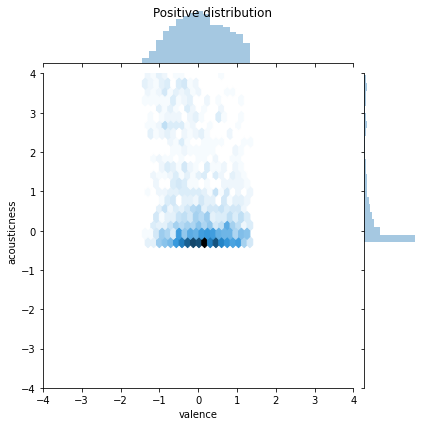

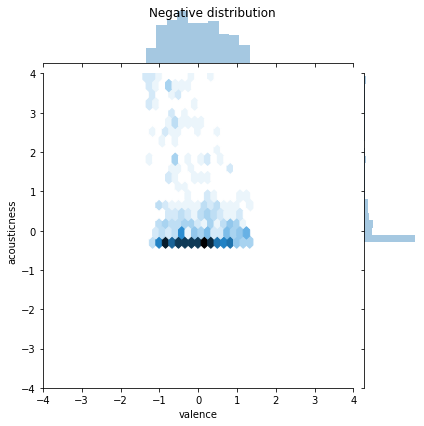

In [12]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)


lim = (-4, 4)
sns.jointplot(pos_df['valence'], pos_df['acousticness'],
              kind='hex', xlim = lim, ylim = lim)
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['valence'], neg_df['acousticness'],
              kind='hex', xlim = lim, ylim = lim)
_ = plt.suptitle("Negative distribution")

## Setup

In [13]:
accuracy = BinaryAccuracy()
precision = Precision()
recall = Recall()
TP = TruePositives()
TN = TrueNegatives()
FP = FalsePositives()
FN = FalseNegatives()
F1 = F1Score(1)
AUC = AUC()

all_metrics = [accuracy, precision, recall, TP, FP, TN, FN, F1, AUC]
metrics = [accuracy, precision, recall, F1, AUC]

In [14]:
def make_model(metrics = all_metrics, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline

In [15]:
EPOCHS = 100
BATCH_SIZE = 1

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=2,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [16]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                368       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.predict(train_features)

array([[0.5298645 ],
       [0.3972104 ],
       [0.47940636],
       ...,
       [0.6327997 ],
       [0.5994142 ],
       [0.70851886]], dtype=float32)

## Initial Bias

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6578


In [19]:
initial_bias = np.log([pos/neg])
initial_bias

array([1.1817272])

In [20]:
model = make_model(output_bias = initial_bias)
model.predict(train_features)

array([[0.770871  ],
       [0.56744885],
       [0.7055084 ],
       ...,
       [0.8144227 ],
       [0.7360742 ],
       [0.75870967]], dtype=float32)

In [21]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5533


In [22]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [23]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [24]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [25]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

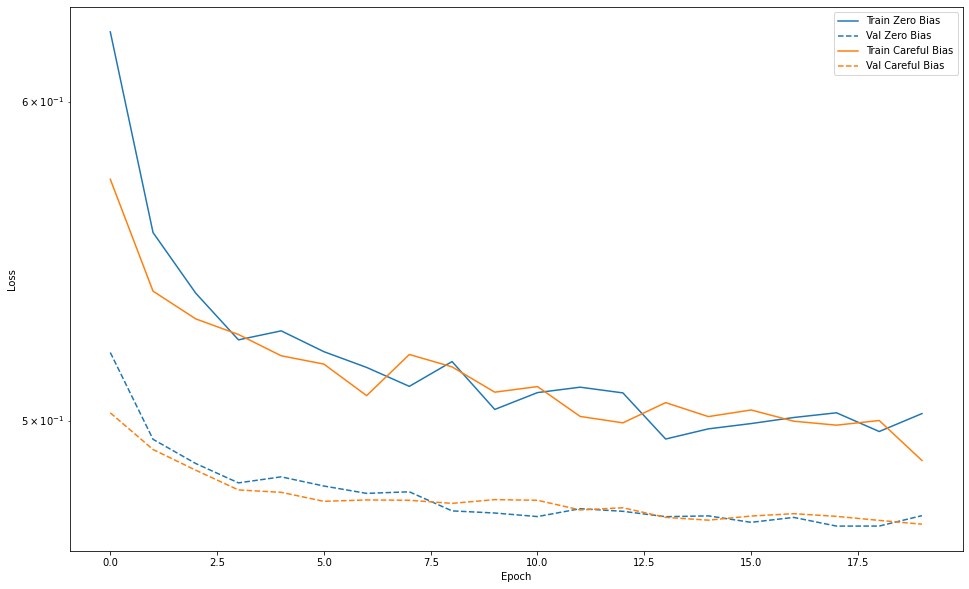

In [26]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [27]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
1772/1772 [==============================] - 3s 2ms/step - loss: 0.5624 - binary_accuracy: 0.7675 - precision: 0.7800 - recall: 0.9706 - true_positives: 1649.0000 - false_positives: 465.0000 - true_negatives: 51.0000 - false_negatives: 50.0000 - f1_score: 0.8682 - auc: 0.5922 - val_loss: 0.4985 - val_binary_accuracy: 0.7968 - val_precision: 0.7950 - val_recall: 1.0000 - val_true_positives: 349.0000 - val_false_positives: 90.0000 - val_true_negatives: 4.0000 - val_false_negatives: 0.0000e+00 - val_f1_score: 0.8813 - val_auc: 0.6302
Epoch 2/100
1772/1772 [==============================] - 2s 1ms/step - loss: 0.5452 - binary_accuracy: 0.7568 - precision: 0.7701 - recall: 0.9704 - true_positives: 1310.0000 - false_positives: 391.0000 - true_negatives: 31.0000 - false_negatives: 40.0000 - f1_score: 0.8648 - auc: 0.5842 - val_loss: 0.4927 - val_binary_accuracy: 0.7923 - val_precision: 0.7927 - val_recall: 0.9971 - val_true_positives: 348.0000 - val_false_positives: 91.0000 - val_

In [28]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([.3, 1])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

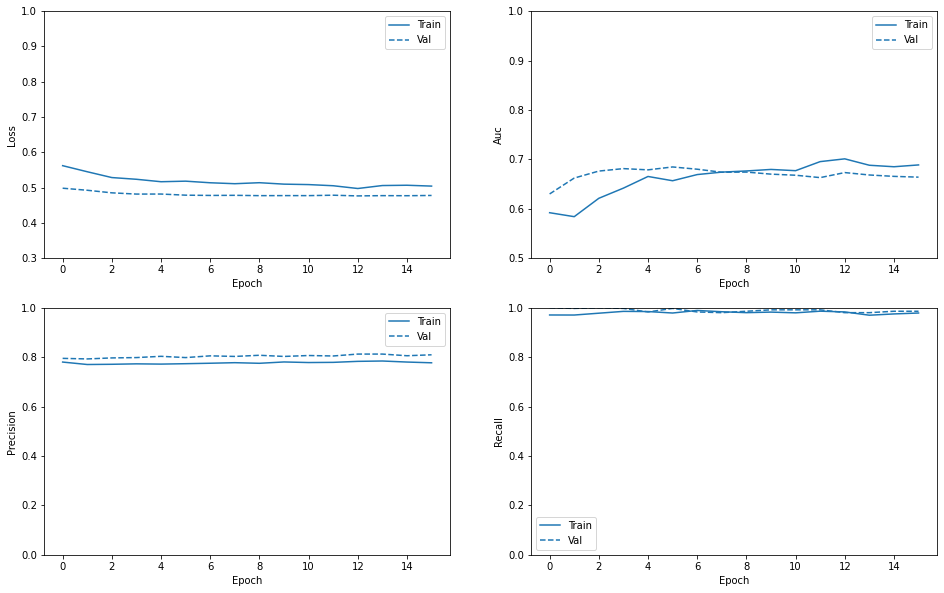

In [29]:
plot_metrics(baseline_history)

In [30]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [31]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Songs Disliked Detected (True Negatives): ', cm[0][0])
  print('Songs Liked Incorrectly Detected (False Positives): ', cm[0][1])
  print('Songs Disliked Missed (False Negatives): ', cm[1][0])
  print('Songs Liked Detected (True Positives): ', cm[1][1])
  print('Total Songs Liked: ', np.sum(cm[1]))

loss            : 0.5206607580184937
binary_accuracy : 0.7617328763008118
precision       : 0.7637362480163574
recall          : 0.9928571581840515
true_positives  : 417.0
false_positives : 129.0
true_negatives  : 5.0
false_negatives : 3.0
f1_score        : [0.862423]
auc             : 0.6625710725784302

Songs Disliked Detected (True Negatives):  5
Songs Liked Incorrectly Detected (False Positives):  129
Songs Disliked Missed (False Negatives):  3
Songs Liked Detected (True Positives):  417
Total Songs Liked:  420


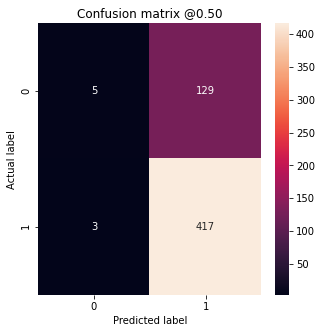

In [32]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(f"{name:16}: {value:}")
print()

plot_cm(test_labels, test_predictions_baseline)

In [33]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,110])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

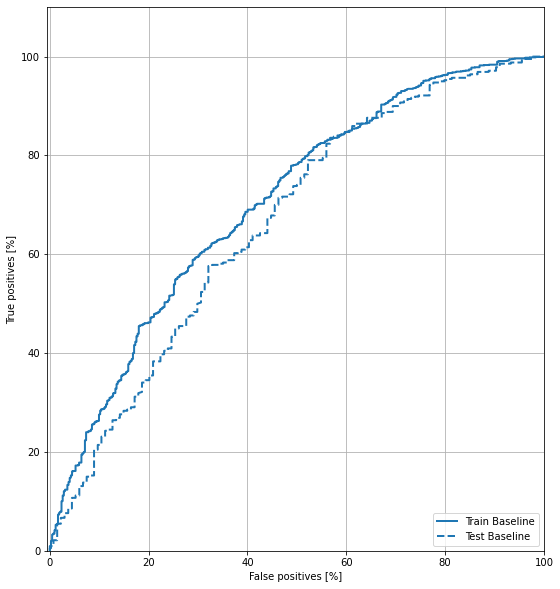

In [34]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## Class Weights

In [35]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.13
Weight for class 1: 0.65


In [36]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
1772/1772 [==============================] - 3s 2ms/step - loss: 0.7753 - binary_accuracy: 0.7111 - precision: 0.7824 - recall: 0.8593 - true_positives: 1521.0000 - false_positives: 423.0000 - true_negatives: 133.0000 - false_negatives: 249.0000 - f1_score: 0.8643 - auc: 0.5803 - val_loss: 0.6354 - val_binary_accuracy: 0.6727 - val_precision: 0.8400 - val_recall: 0.7221 - val_true_positives: 252.0000 - val_false_positives: 48.0000 - val_true_negatives: 46.0000 - val_false_negatives: 97.0000 - val_f1_score: 0.8813 - val_auc: 0.6491
Epoch 2/100
1772/1772 [==============================] - 3s 2ms/step - loss: 0.6907 - binary_accuracy: 0.6484 - precision: 0.8062 - recall: 0.7089 - true_positives: 957.0000 - false_positives: 230.0000 - true_negatives: 192.0000 - false_negatives: 393.0000 - f1_score: 0.8648 - auc: 0.6080 - val_loss: 0.6075 - val_binary_accuracy: 0.7065 - val_precision: 0.8390 - val_recall: 0.7765 - val_true_positives: 271.0000 - val_false_positives: 52.0000 - val

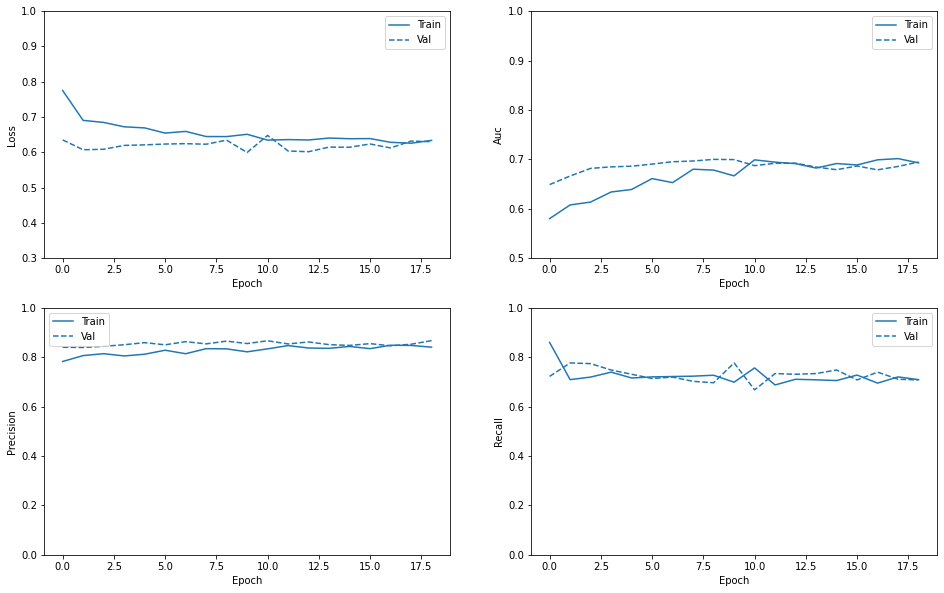

In [37]:
plot_metrics(weighted_history)

In [38]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss            : 0.6586644053459167
binary_accuracy : 0.6299638748168945
precision       : 0.826747715473175
recall          : 0.6476190686225891
true_positives  : 272.0
false_positives : 57.0
true_negatives  : 77.0
false_negatives : 148.0
f1_score        : [0.862423]
auc             : 0.6535536646842957

Songs Disliked Detected (True Negatives):  77
Songs Liked Incorrectly Detected (False Positives):  57
Songs Disliked Missed (False Negatives):  148
Songs Liked Detected (True Positives):  272
Total Songs Liked:  420


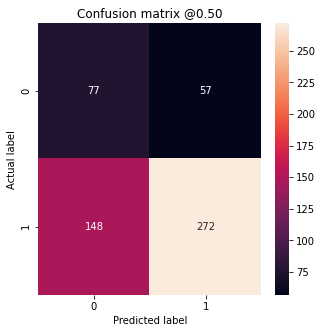

In [39]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(f"{name:16}: {value:}")
print()

plot_cm(test_labels, test_predictions_weighted)

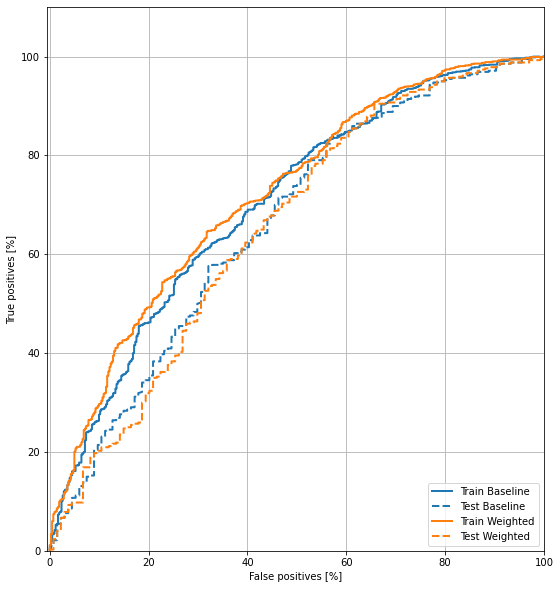

In [40]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

In [88]:
temp_neg, temp_pos = np.bincount(train_labels)
temp_total = temp_neg + temp_pos
print(f"Liked")
print(f"Total: {temp_total}")
print(f"Positive: {temp_pos} ({100 * temp_pos / total:.2f}% of total")
print(f"Negative: {temp_neg} ({100 * temp_neg / total:.2f}% of total)")

Liked
Total: 1772
Positive: 1350 (48.75% of total
Negative: 422 (15.24% of total)


In [89]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [90]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(422, 22)

In [91]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(844, 22)

In [92]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [93]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.5312085  -1.90577778 -1.92654922  0.          0.13495575  3.71273193
  0.03140596 -0.25766491 -0.79033404 -1.11944853 -0.51893109  0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.        ]

Label:  1


In [94]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [95]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.0


In [96]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

1300.0

In [97]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
1300/1300 [==============================] - 8s 6ms/step - loss: 0.7341 - binary_accuracy: 0.5318 - precision: 0.6168 - recall: 0.5162 - true_positives: 557.0000 - false_positives: 346.0000 - true_negatives: 429.0000 - false_negatives: 522.0000 - f1_score: 0.7358 - auc: 0.5591 - val_loss: 0.6749 - val_binary_accuracy: 0.5914 - val_precision: 0.8443 - val_recall: 0.5903 - val_true_positives: 206.0000 - val_false_positives: 38.0000 - val_true_negatives: 56.0000 - val_false_negatives: 143.0000 - val_f1_score: 0.8813 - val_auc: 0.6246
Epoch 2/100
1300/1300 [==============================] - 6s 5ms/step - loss: 0.6668 - binary_accuracy: 0.5846 - precision: 0.5937 - recall: 0.5919 - true_positives: 393.0000 - false_positives: 269.0000 - true_negatives: 367.0000 - false_negatives: 271.0000 - f1_score: 0.6762 - auc: 0.6288 - val_loss: 0.6323 - val_binary_accuracy: 0.6795 - val_precision: 0.8416 - val_recall: 0.7307 - val_true_positives: 255.0000 - val_false_positives: 48.0000 - val

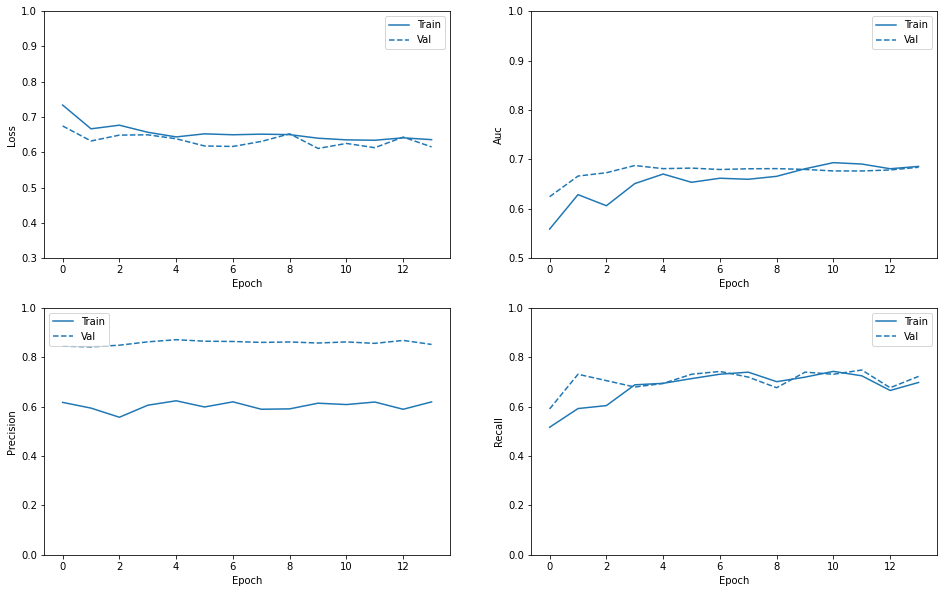

In [98]:
plot_metrics(resampled_history)

In [99]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss            : 0.6646509766578674
binary_accuracy : 0.6028881072998047
precision       : 0.826797366142273
recall          : 0.6023809313774109
true_positives  : 253.0
false_positives : 53.0
true_negatives  : 81.0
false_negatives : 167.0
f1_score        : [0.862423]
auc             : 0.6453180313110352

Songs Disliked Detected (True Negatives):  81
Songs Liked Incorrectly Detected (False Positives):  53
Songs Disliked Missed (False Negatives):  167
Songs Liked Detected (True Positives):  253
Total Songs Liked:  420


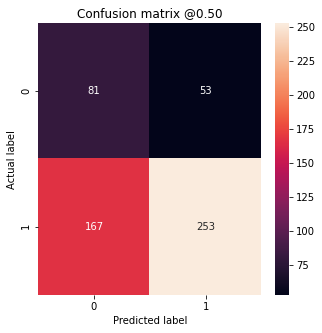

In [100]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(f"{name:16}: {value:}")
print()

plot_cm(test_labels, test_predictions_resampled)

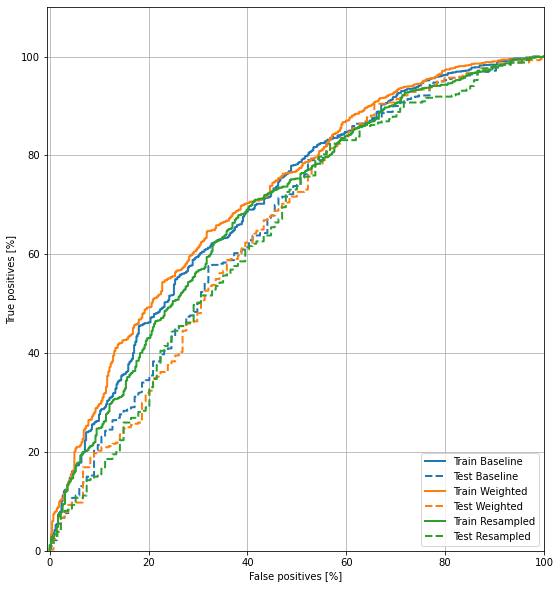

In [101]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')